# IMaGES on ROI time series

In [1]:
import os
from os.path import join as pjoin
import glob
import pandas as pd
import numpy as np
import pydot
from IPython.display import SVG
from pycausal import pycausal as pc
from pycausal import search as s
import networkx as nx
from networkx.drawing import nx_pydot
import itertools

In [2]:
def getdfs(csvdir):
    """give us list of data frames for csv files in directory"""
    dfs = []
    for csvfile in glob.glob(csvdir_allruns + os.sep + "*.csv"):
        df = pd.read_csv(csvfile)
        dfs.append(df)
    return dfs

## Preprocessed BOLD data

In [3]:
# directory with csv files for roi time series (seperate csv file for each run)
csvdir_allruns = pjoin('/host', 'famfaces', 'extract_meants', 'csv', 'allruns')
dfs = getdfs(csvdir_allruns)

In [4]:
# perform images search
pc.start_vm() # start
images = s.imagesSemBic(dfs, verbose = True)
pc.stop_vm() # stop

In [5]:
# show nodes
# images.getNodes()

In [6]:
# show edges
# images.getEdges()

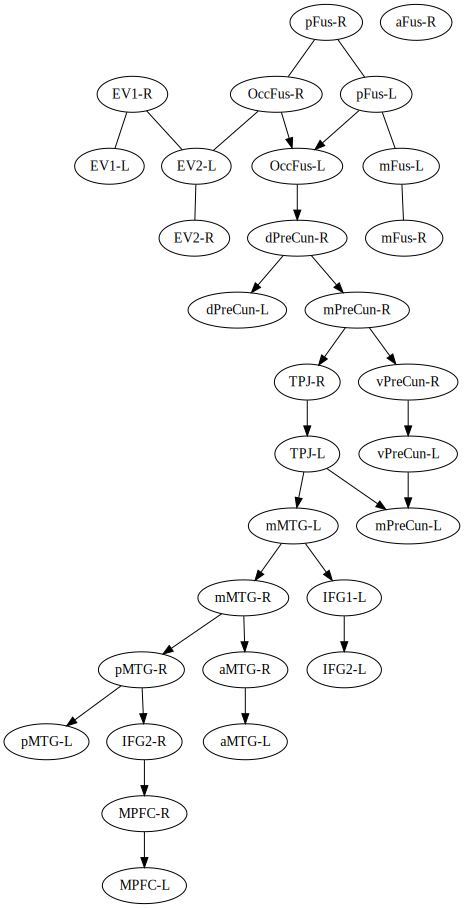

In [7]:
# render resulting graph
dot = images.getDot()
svg_str = dot.create_svg(prog='dot')
SVG(svg_str)

## Residuals 1

From a nuisance model with motion parameters, outliers, and button press as regressors.

In [8]:
# nuisance data with button press
dfs_nb = getdfs(pjoin('/host', 'famfaces', 'extract_meants_nuisance_button', 'csv', 'run*'))

In [9]:
# perform images search
pc.start_vm() # start
images_nb = s.imagesSemBic(dfs_nb, verbose = True)
pc.stop_vm() # stop

In [10]:
# nodes and edges
# images_nb.getNodes()
# images_nb.getEdges()  

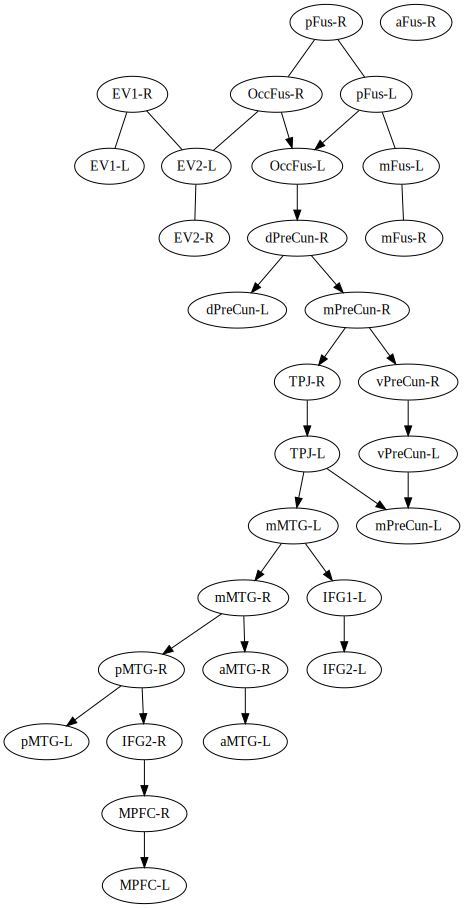

In [11]:
# render resulting graph
dot_nb = images_nb.getDot()
SVG(dot_nb.create_svg(prog='dot'))

# extract adjacencies from images object

In [23]:
def splitpair(pair):
    """
    split string containing two nodes into a tuple of two nodes.
    ignore directedness of connection.
    Used in get_adjacencies.
    """
    split = tuple([label.replace('- ', '').replace('> ', '').replace(' ', '') # looks ugly, but is supposedly faster
                   for label in pair.split('--')])
    return split

In [24]:
def get_adjacencies(images_instance):
    """
    returns a list of tuples of connected nodes
    """
    
    # get edges and convert from unicode to string
    images_edges = images_instance.edges
    edgestrings = [str(edge) for edge in images_edges]
    
    # split the strings to get tuples, turn into arrays and sort
    edges = np.array([splitpair(pair) for pair in edgestrings])
    sortededges = edges[np.argsort(edges[:, 0])]
    
    return sortededges

In [34]:
# apply above functions and inspect results
connections = get_adjacencies(images_nb)

print('shape of adjacency array: ' + str(np.shape(connections)) + '\n')
print(connections)

shape of adjacency array: (30, 2)

[['EV1-R' 'EV2-L']
 ['EV1-R' 'EV1-L']
 ['EV2-L' 'EV2-R']
 ['IFG1-L' 'IFG2-L']
 ['IFG2-R' 'MPFC-R']
 ['MPFC-R' 'MPFC-L']
 ['OccFus-L' 'dPreCun-R']
 ['OccFus-R' 'EV2-L']
 ['OccFus-R' 'OccFus-L']
 ['TPJ-L' 'mPreCun-L']
 ['TPJ-L' 'mMTG-L']
 ['TPJ-R' 'TPJ-L']
 ['aMTG-R' 'aMTG-L']
 ['dPreCun-R' 'dPreCun-L']
 ['dPreCun-R' 'mPreCun-R']
 ['mFus-L' 'mFus-R']
 ['mMTG-L' 'mMTG-R']
 ['mMTG-L' 'IFG1-L']
 ['mMTG-R' 'pMTG-R']
 ['mMTG-R' 'aMTG-R']
 ['mPreCun-R' 'vPreCun-R']
 ['mPreCun-R' 'TPJ-R']
 ['pFus-L' 'OccFus-L']
 ['pFus-L' 'mFus-L']
 ['pFus-R' 'OccFus-R']
 ['pFus-R' 'pFus-L']
 ['pMTG-R' 'pMTG-L']
 ['pMTG-R' 'IFG2-R']
 ['vPreCun-L' 'mPreCun-L']
 ['vPreCun-R' 'vPreCun-L']]


In [17]:
# get nodes in string format (instead of unicode)
# actually I don't think I need that.
# nodes = [str(node) for node in images_nb.nodes]

In [37]:
firstrow = connections[0]
firstrow

array(['EV1-R', 'EV2-L'],
      dtype='|S9')

In [38]:
firstrow[1]

'EV2-L'

In [39]:
connections[connections[:,0]=='EV2-L']

array([['EV2-L', 'EV2-R']],
      dtype='|S9')

In [18]:
zeros = np.zeros(shape=(30,30))
np.shape(zeros)

(30, 30)

**TODO:** create zero-array with shape 30x30. for row in rows: Look up index i of second element in first column. Fill i-th column of row with a 1.

In [45]:
# boolian array indicating the occurance of an element in connections array
index = np.isin(connections, 'EV2-L')
index

array([[False,  True],
       [False, False],
       [ True, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False,  True],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False]], dtype=bool)

# to networkx

In [133]:
# switch from dot to nx graph
graph_raw = nx_pydot.from_pydot(dot)
graph_nb = nx_pydot.from_pydot(dot_nb)

# ALTERNATIVELY: maybe it could be done with pydot. instead of nx. method

TODO: get adjacency matrices for two graphs, flat them, calc binary correlation of sorts. <br>
TODO: beware that the order of pairwise comparisons in the adjacency matrix / array must be the same.

In [134]:
# get adjacency matrix as tuples.
# (For directed graphs, entry i,j corresponds to an edge from i to j.)
# nx.adjacency_matrix?

#am_raw = nx.adjacency_matrix(graph_raw)
#am_nb = nx.adjacency_matrix(graph_nb)

In [143]:
# adjacency matrix as numpy array
# nx.convert_matrix.to_numpy_matrix?

am_raw = nx.convert_matrix.to_numpy_matrix(graph_raw)
am_nb = nx.convert_matrix.to_numpy_matrix(graph_nb)

# check if the two graphs have the same shape
assert np.shape(am_raw) == np.shape(am_nb)

### interesting nx methods

In [24]:
# show predecessors for a node. successors also possible.
# graph.predecessors('pMTG-R')

In [47]:
# generate node positions in a circle for plotting
# nx.circular_layout(graph)